### Sensibilité globale – Indices de Sobol multidimensionnels

#### Objectif
Ce notebook présente l’implémentation des indices de Sobol multidimensionnels à l’aide de la méthode **Pick & Freeze** afin d’analyser la sensibilité globale d’un modèle à entrées incertaines. La sortie du modèle est vectorielle, et l’importance des variables d’entrée est mesurée à l’aide des indices de Sobol d’ordre 1 et des indices totaux.


On considère un vecteur d’entrées aléatoires $ X = (X_1, X_2, X_3, X_4, X_5)$ dont les composantes sont supposées indépendantes. Les variables d’entrée suivent des lois uniformes indépendantes : $ X_1, \dots, X_5 \sim \mathcal U([0,1])$

Le modèle étudié est un modèle déterministe à sortie multidimensionnelle : $ f : \mathbb{R}^5 \longrightarrow \mathbb{R}^2 $

La première composante de la sortie correspond à la fonction de Bratley, définie par :
$ Y_1 = \sum_{i=1}^{5} (-1)^i \prod_{j=1}^{i} X_j $ 

La seconde composante correspond à une fonction discontinue donnée par :
$ Y_2 = X_1 \mathbf{1}_{X_3 < 0.5} + X_2^2 \mathbf{1}_{X_3 \ge 0.5} + X_3, $

La sortie du modèle est donc le vecteur $ Y = (Y_1, Y_2)$
ce qui permet d’illustrer le calcul des indices de Sobol multidimensionnels dans deux situations contrastées : une fonction régulière et une fonction discontinue.


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# dimensions
p = 5          
k = 2 
N = 500000        

N_list = [1000, 2000, 5000, 10000]
seeds = list(range(20))   

alpha = 0.05

In [57]:
def pick_and_freeze(A, B, u):
    """
    A, B : matrices (N, p), échantillons iid indépendants
    u    : ensemble d'indices (ex : {0}, {1,2})

    retourne X^(u) = (X_u, X'_{~u}) sous forme de matrice (N, p)
    """
    X_u = A.copy()
    all_idx = set(range(A.shape[1]))
    comp_u = list(all_idx - set(u))
    X_u[:, comp_u] = B[:, comp_u]
    return X_u

def f(X):
    """
    Modèle déterministe
    Entrée  : X de taille (N, 5)
    Sortie  : Y de taille (N, 2)
    """

    # sortie 1 : fonction de Bratley (régulière)
    Y1 = (
        - X[:, 0]
        + X[:, 0] * X[:, 1]
        - X[:, 0] * X[:, 1] * X[:, 2]
        + X[:, 0] * X[:, 1] * X[:, 2] * X[:, 3]
        - X[:, 0] * X[:, 1] * X[:, 2] * X[:, 3] * X[:, 4]
    )

    # sortie 2 : fonction discontinue
    Y2 = np.where(X[:, 2] < 0.5, X[:, 0], X[:, 1]**2) + X[:, 2]

    Y = np.column_stack((Y1, Y2))

    return Y

In [58]:
def compute_Su_multi(Y, Yu):
    Yc  = Y  - Y.mean(axis=0)
    Yuc = Yu - Yu.mean(axis=0)

    C_u   = (Yc.T @ Yuc) / Y.shape[0]
    Sigma = (Yc.T @ Yc)  / Y.shape[0]

    return np.trace(C_u) / np.trace(Sigma)



def calc_sobol_multi(N, p, seed=0):
    """
    Calcule S1[i] et Stot[i] pour i = 0..p-1.

    S1[i]   = S^{i}      →  u = {i}           (effet seul de X_i)
    Stot[i] = 1 - S^{~i} →  ~i = {0..p-1}\{i} (effet total de X_i)

    Pick & Freeze :
        S^{i}  : on tire X^(i) = (A_i, B_{~i})  →  on "freeze" X_i
        S^{~i} : on tire X^(~i) = (A_{~i}, B_i) →  on "freeze" tout sauf X_i
    """
    rng = np.random.default_rng(seed)
    A   = rng.uniform(size=(N, p))   # matrice de base
    B   = rng.uniform(size=(N, p))   # copie indépendante
    Y_A = f(A)                       # (N, k) – sortie de référence

    S1   = np.zeros(p)
    Stot = np.zeros(p)

    for i in range(p):
        # ordre 1 : seule X_i vient de A, le reste de B
        S1[i] = compute_Su_multi(Y_A, f(pick_and_freeze(A, B, {i})))

        # total : tout sauf X_i vient de A, X_i vient de B
        S_comp = compute_Su_multi(Y_A, f(pick_and_freeze(A, B, set(range(p)) - {i})))
        Stot[i] = 1.0 - S_comp

    return S1, Stot

<>:17: SyntaxWarning: invalid escape sequence '\{'
<>:17: SyntaxWarning: invalid escape sequence '\{'
C:\Users\achle\AppData\Local\Temp\ipykernel_16832\1290742817.py:17: SyntaxWarning: invalid escape sequence '\{'
  Stot[i] = 1 - S^{~i} →  ~i = {0..p-1}\{i} (effet total de X_i)


In [59]:
S1, Stot1 = calc_sobol_multi(N, p, seed=0)

print(f"Sobol (estimateur 1) — N={N}")
for i in range(p):
    print(f"X{i+1}:  S = {S1[i]:.4f}   Stot = {Stot1[i]:.4f}")


Sobol (estimateur 1) — N=500000
X1:  S = 0.3141   Stot = 0.4449
X2:  S = 0.1585   Stot = 0.2969
X3:  S = 0.2690   Stot = 0.5073
X4:  S = 0.0028   Stot = 0.0054
X5:  S = 0.0027   Stot = 0.0053


In [60]:
def compute_Su_multi_est2(Y, Yu_list):
    """
    Y        : (N, k)
    Yu_list  : liste de m matrices (N, k), sorties gelées indépendantes
    """
    N, k = Y.shape
    m = len(Yu_list)

    Yc = Y - Y.mean(axis=0)

    # moyenne conditionnelle empirique
    Z = sum(Yu_list) / m
    Zc = Z - Z.mean(axis=0)

    # covariance croisée et covariance totale
    C_u   = (Yc.T @ Zc) / N
    Sigma = (Yc.T @ Yc) / N

    return np.trace(C_u) / np.trace(Sigma)


def calc_sobol_multi_est2(N, p, m=5, seed=0):
    rng = np.random.default_rng(seed)

    A = rng.uniform(size=(N, p))
    Y = f(A)

    S1   = np.zeros(p)
    Stot = np.zeros(p)

    for i in range(p):
        # --- S_i (closed) ---
        Yu_list = []
        for _ in range(m):
            B = rng.uniform(size=(N, p))
            Yu_list.append(f(pick_and_freeze(A, B, {i})))
        S1[i] = compute_Su_multi_est2(Y, Yu_list)

        # --- S_i^{tot} ---
        Yu_comp_list = []
        for _ in range(m):
            B = rng.uniform(size=(N, p))
            Yu_comp_list.append(f(pick_and_freeze(A, B, set(range(p)) - {i})))
        Stot[i] = 1.0 - compute_Su_multi_est2(Y, Yu_comp_list)

    return S1, Stot


In [61]:
S2, Stot2 = calc_sobol_multi_est2(N, p, m=5, seed=0)

print(f"Sobol (estimateur 2) — N={N}")
for i in range(p):
    print(f"X{i+1}:  S = {S2[i]:.4f}   Stot = {Stot2[i]:.4f}")


Sobol (estimateur 2) — N=500000
X1:  S = 0.3138   Stot = 0.4458
X2:  S = 0.1580   Stot = 0.2973
X3:  S = 0.2688   Stot = 0.5064
X4:  S = 0.0018   Stot = 0.0055
X5:  S = 0.0021   Stot = 0.0053


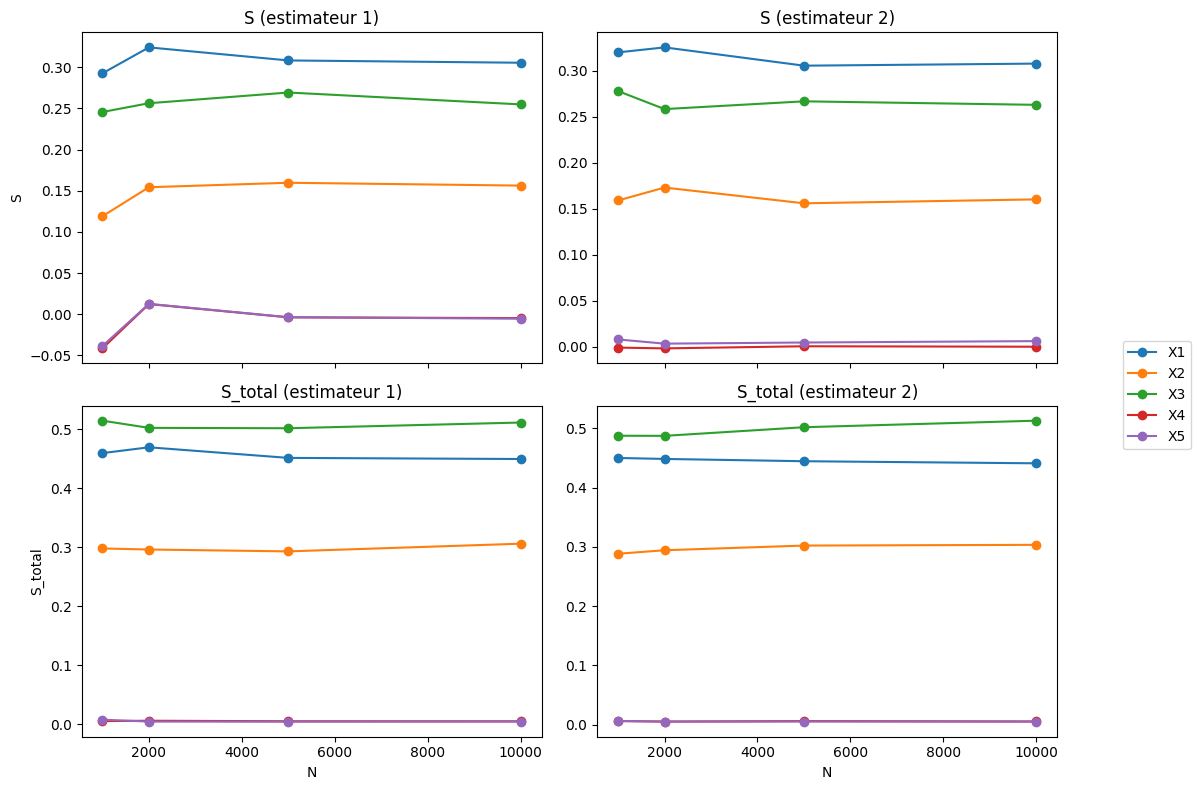

In [62]:
S1_e1   = np.zeros((len(N_list), p))
St_e1   = np.zeros_like(S1_e1)
S1_e2   = np.zeros_like(S1_e1)
St_e2   = np.zeros_like(S1_e1)

# calculs
for j, N in enumerate(N_list):
    S1_e1[j], St_e1[j] = calc_sobol_multi(N, p)
    S1_e2[j], St_e2[j] = calc_sobol_multi_est2(N, p, m=5)

# ===== PLOTS =====
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# ordre 1 — estimateur 1
for i in range(p):
    axs[0,0].plot(N_list, S1_e1[:,i], marker='o', label=f"X{i+1}")
axs[0,0].set_title("S (estimateur 1)")
axs[0,0].set_ylabel("S")

# ordre 1 — estimateur 2
for i in range(p):
    axs[0,1].plot(N_list, S1_e2[:,i], marker='o')
axs[0,1].set_title("S (estimateur 2)")

# total — estimateur 1
for i in range(p):
    axs[1,0].plot(N_list, St_e1[:,i], marker='o')
axs[1,0].set_title("S_total (estimateur 1)")
axs[1,0].set_ylabel("S_total")
axs[1,0].set_xlabel("N")

# total — estimateur 2
for i in range(p):
    axs[1,1].plot(N_list, St_e2[:,i], marker='o')
axs[1,1].set_title("S_total (estimateur 2)")
axs[1,1].set_xlabel("N")


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()



Lorsque le nombre de simulations Monte Carlo augmente, les estimations des indices de Sobol se stabilisent vers des valeurs limites
Les résultats montrent que les variables X1 et X3 sont les plus influentes sur la sortie du modèle, avec des indices de Sobol élevés. La variable X2 a une influence modérée, tandis que X4 et X5 ont un impact négligeable, leurs indices étant proches de zéro. La différence entre les indices d’ordre 1 et totaux met en évidence la présence d’interactions, notamment pour X3

C:\Users\achle\AppData\Local\Temp\ipykernel_16832\1513274143.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(S1_e1, labels=[f"X{i+1}" for i in range(p)])
C:\Users\achle\AppData\Local\Temp\ipykernel_16832\1513274143.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(S1_e2, labels=[f"X{i+1}" for i in range(p)])


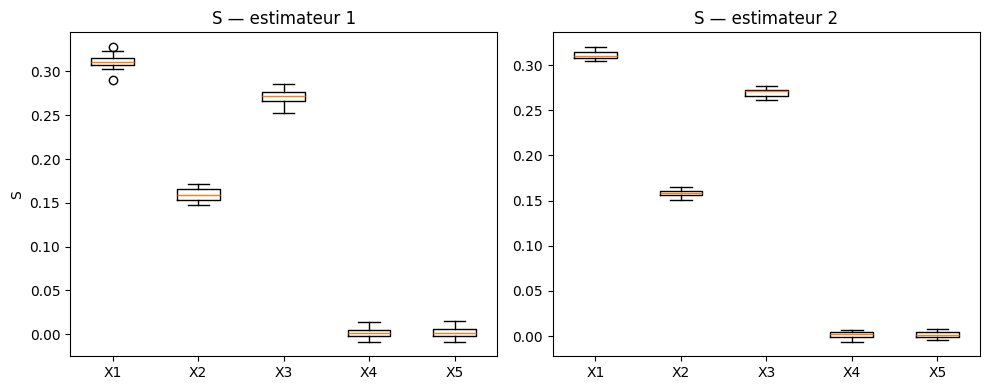

In [63]:
N=10000
S1_e1 = np.zeros((len(seeds), p))
S1_e2 = np.zeros_like(S1_e1)

for j, s in enumerate(seeds):
    S1_e1[j], _ = calc_sobol_multi(N, p, seed=s)
    S1_e2[j], _ = calc_sobol_multi_est2(N, p, m=5, seed=s)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.boxplot(S1_e1, labels=[f"X{i+1}" for i in range(p)])
plt.title("S — estimateur 1")
plt.ylabel("S")

plt.subplot(1,2,2)
plt.boxplot(S1_e2, labels=[f"X{i+1}" for i in range(p)])
plt.title("S — estimateur 2")

plt.tight_layout()
plt.show()


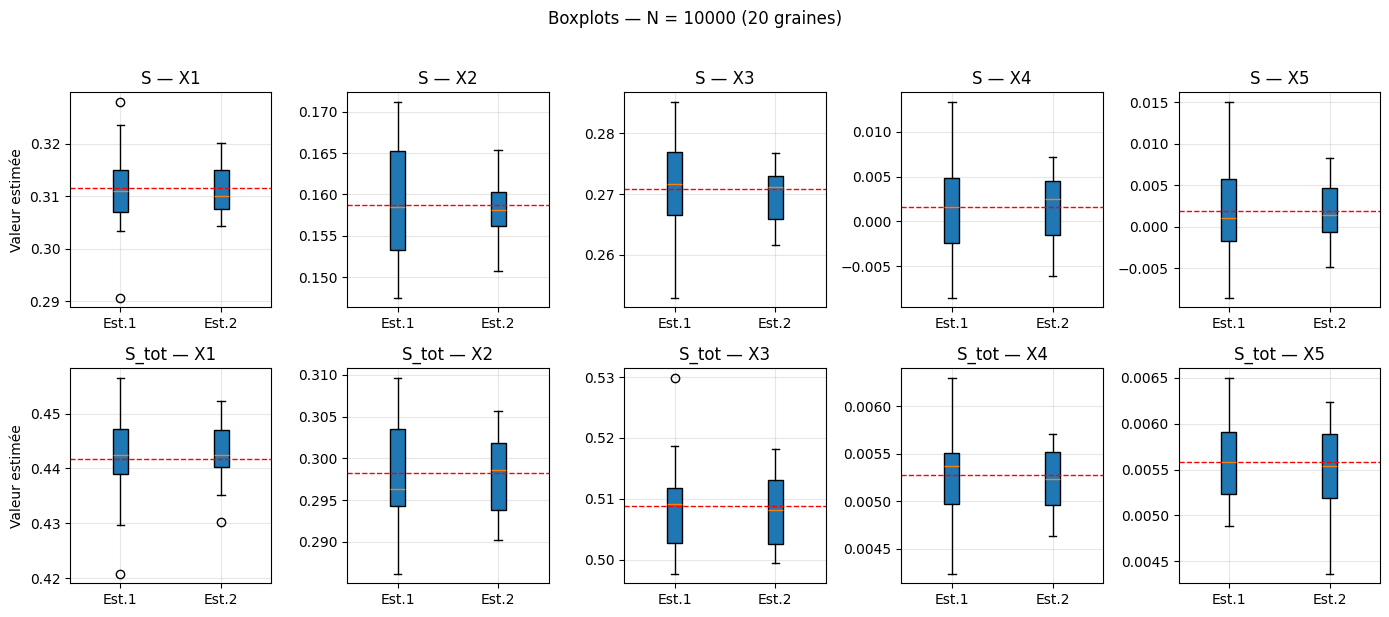

In [68]:
N=10000
# stockage
S1_e1 = np.zeros((len(seeds), p))
S1_e2 = np.zeros_like(S1_e1)
St_e1 = np.zeros_like(S1_e1)
St_e2 = np.zeros_like(S1_e1)

# calculs
for j, s in enumerate(seeds):
    S1, St = calc_sobol_multi(N, p, seed=s)
    S1_e1[j], St_e1[j] = S1, St

    S1b, Stb = calc_sobol_multi_est2(N, p, m=m, seed=s)
    S1_e2[j], St_e2[j] = S1b, Stb

# valeurs de référence
S1_ref = S1_e1.mean(axis=0)
St_ref = St_e1.mean(axis=0)



fig, axes = plt.subplots(2, p, figsize=(14, 6))          # pas de sharey

for i in range(p):
    # ── S1 ──
    axes[0, i].boxplot([S1_e1[:, i], S1_e2[:, i]],
                       tick_labels=["Est.1", "Est.2"],
                       patch_artist=True)
    axes[0, i].axhline(S1_ref[i], color="red", linestyle="--", linewidth=1)
    axes[0, i].set_title(f"S — X{i+1}")
    axes[0, i].grid(alpha=0.3)
 

    # ── Stot ──
    axes[1, i].boxplot([St_e1[:, i], St_e2[:, i]],
                       tick_labels=["Est.1", "Est.2"],
                       patch_artist=True)
    axes[1, i].axhline(St_ref[i], color="red", linestyle="--", linewidth=1)
    axes[1, i].set_title(f"S_tot — X{i+1}")
    axes[1, i].grid(alpha=0.3)

axes[0, 0].set_ylabel("Valeur estimée")
axes[1, 0].set_ylabel("Valeur estimée")

plt.suptitle(f"Boxplots — N = {N} ({len(seeds)} graines)", y=1.02)
plt.tight_layout()
plt.show()


Cette figure représente la dispersion Monte Carlo des estimations des indices de Sobol pour une taille d’échantillon fixée. Chaque boîte correspond à la distribution des estimations obtenues en faisant varier la seed. La comparaison met en évidence une variabilité plus faible pour l’estimateur 2


